In [9]:
#standard
import os
import warnings
warnings.filterwarnings('ignore')
import pickle

#third party
import numpy as np
from nilearn import plotting
import nilearn
import matplotlib.pyplot as plt

In [10]:
def calculate_noiseceiling(betas, n: int=1):
    """
    Calculate the standard deviation across trials, square the result,
    average across images, and then take the square root. The result is
    the estimate of the 'noise standard deviation'. 
    Parameters:
    betas: beta estimates in shape (vertices, num_reps, num_stimuli)
    Returns:
    ncsnr: noise-ceiling SNR at each voxel in shape (voxel_x, voxel_y, voxel_z) as ratio between signal std and noise std
    noiseceiling: noise ceiling at each voxel in shape (voxel_x, voxel_y, voxel_z) as % of explainable variance 
    Code adapted from GLMsingle example: https://github.com/cvnlab/GLMsingle/blob/main/examples/example9_noiseceiling.ipynb
    """
    assert(len(betas.shape) == 3)
    numvertices = betas.shape[0]
    num_reps = betas.shape[1]
    num_vids = betas.shape[2]
    noisesd = np.sqrt(np.mean(np.power(np.std(betas,axis=1,keepdims=1,ddof=1),2),axis=2)).reshape((numvertices,))

    # Calculate the total variance of the single-trial betas.
    totalvar = np.power(np.std(np.reshape(betas, (numvertices , num_reps*num_vids)), axis=1),2)

    # Estimate the signal variance and positively rectify.
    signalvar = totalvar - np.power(noisesd,2)

    signalvar[signalvar < 0] = 0
    # Compute ncsnr as the ratio between signal standard deviation and noise standard deviation.
    ncsnr = np.sqrt(signalvar) / noisesd

    # Compute noise ceiling in units of percentage of explainable variance
    noiseceiling = 100 * (np.power(ncsnr,2) / (np.power(ncsnr,2) + 1/n))
    return ncsnr, noiseceiling

In [11]:
#setup paths
dataset_root = "/data/vision/oliva/scratch/datasets/BOLDMomentsDataset" #"/your/path/to/BOLDMomentsDataset"
subject = 1 #which subject 1-10 you want to look at
fmri_path = os.path.join(dataset_root,"derivatives", "versionB", "fsaverage","GLM")
subject = f"sub-{int(subject):02}"
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')
#define subject and session. Change 'n' to get the noiseceiling for single trial (n=1) or trial average (n=3, n=10 for train, test respectively)
n_task = {'train': [1,3], 'test': [1,10]}

#define your plotting views
views = ['lateral', 'ventral'] #['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior']

(102, 10, 163842)
sub-01 test left n=1 max noiseceiling: 56.16854630228818


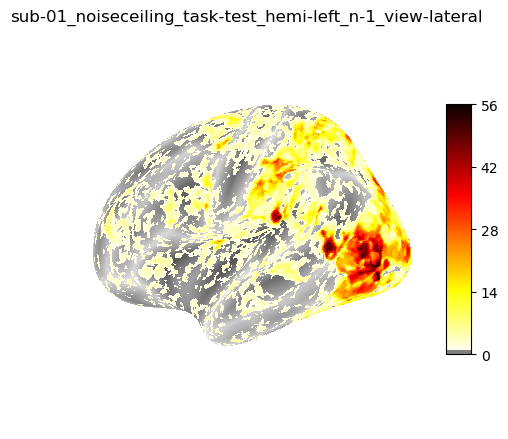

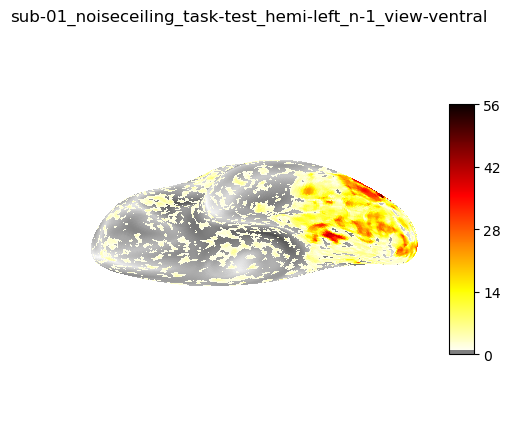

sub-01 test left n=10 max noiseceiling: 92.76131640795477


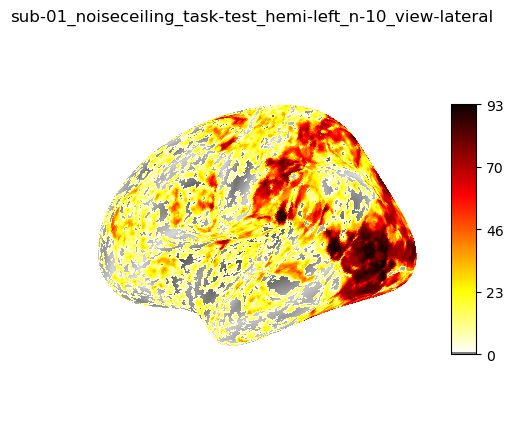

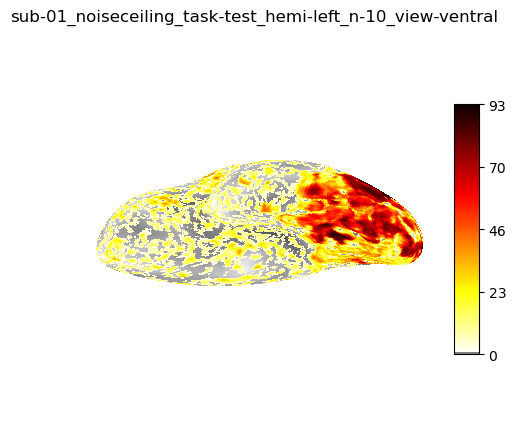

(102, 10, 163842)
sub-01 test right n=1 max noiseceiling: 65.81447088900777


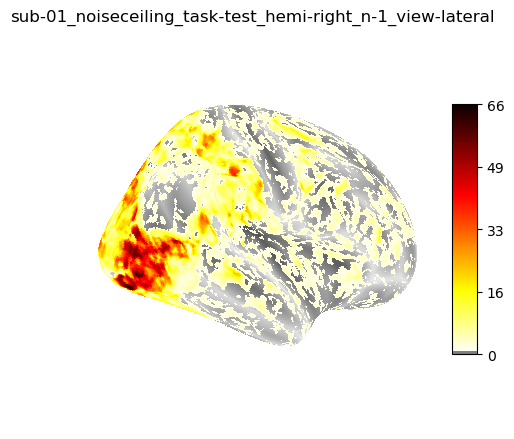

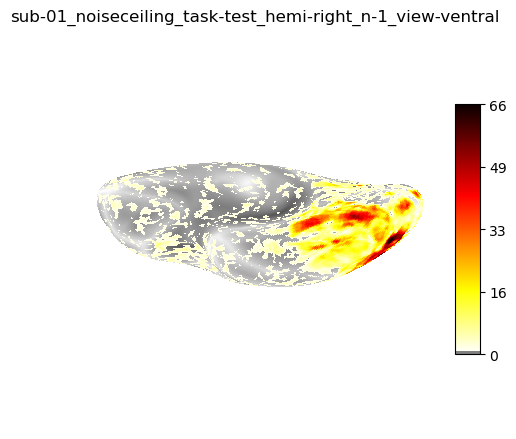

sub-01 test right n=10 max noiseceiling: 95.06225104226353


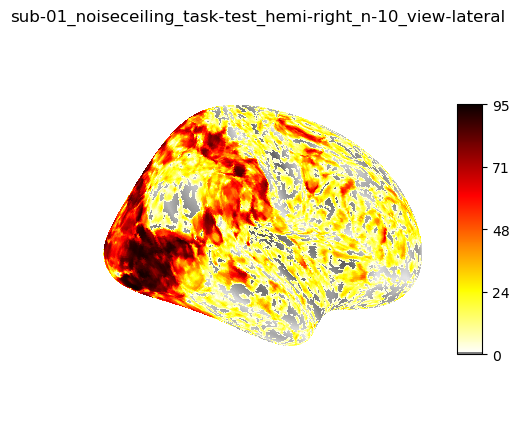

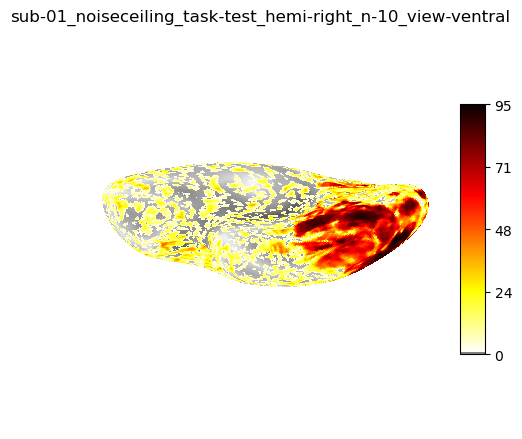

(1000, 3, 163842)
sub-01 train left n=1 max noiseceiling: 53.01012380513368


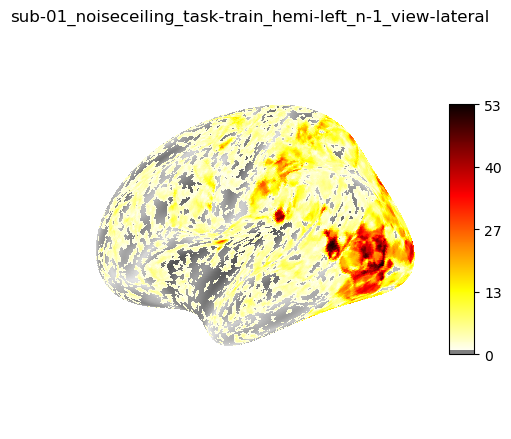

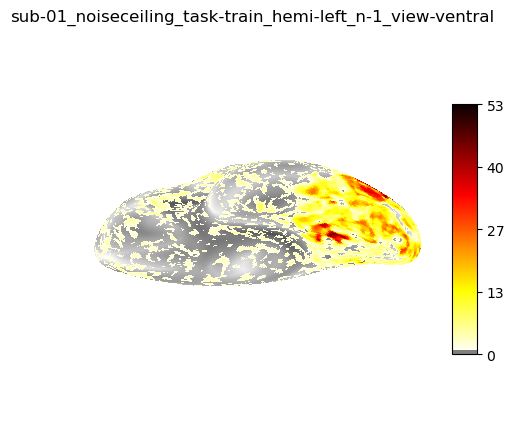

sub-01 train left n=3 max noiseceiling: 77.1916223090082


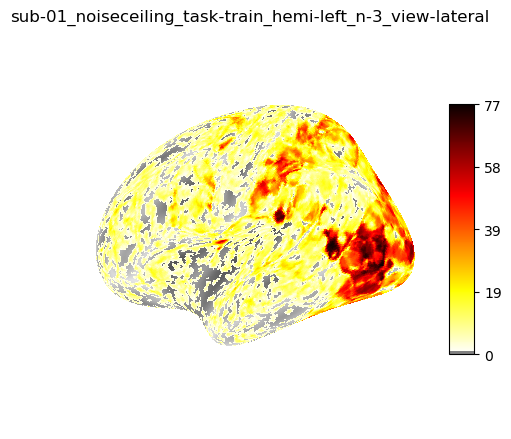

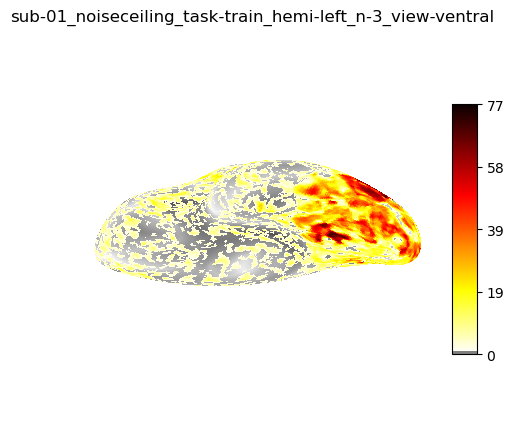

(1000, 3, 163842)
sub-01 train right n=1 max noiseceiling: 61.74775244552298


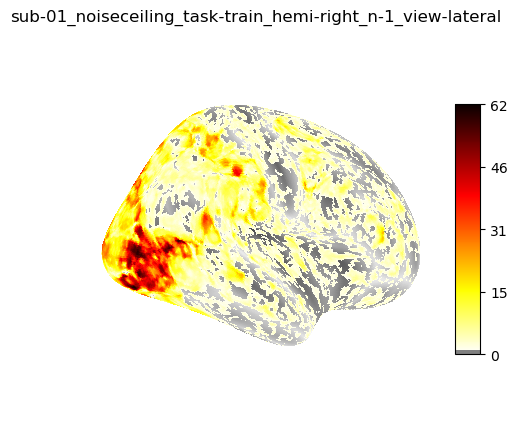

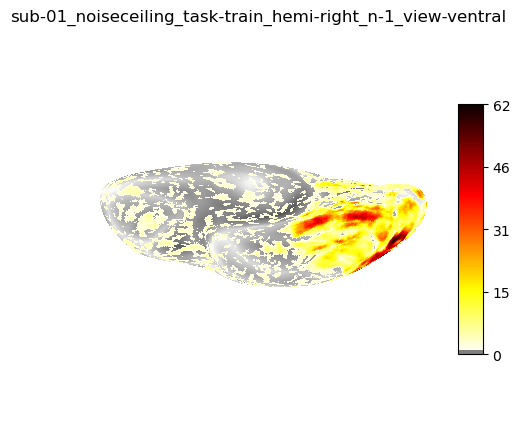

sub-01 train right n=3 max noiseceiling: 82.88455619135384


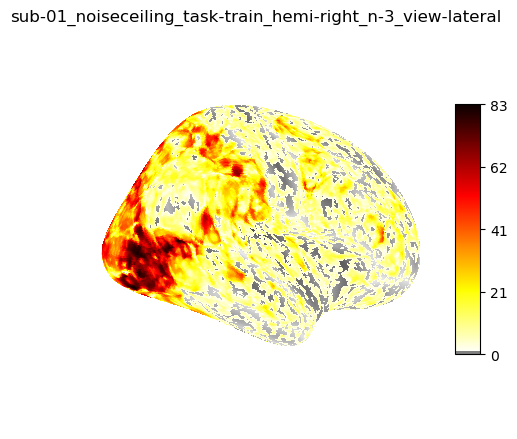

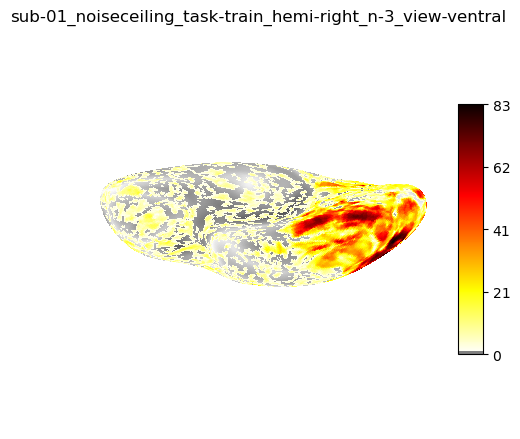

In [12]:
for task in ['test','train']:
    for hemi in ['left','right']:
        with open(os.path.join(fmri_path, subject, "prepared_betas", f"{subject}_organized_betas_task-{task}_hemi-{hemi}_normalized.pkl"), 'rb') as f:
            fmri_data, _ = pickle.load(f)
        print(fmri_data.shape)
        betas = fmri_data.T

        for n in n_task[task]:
            ncsnr, noiseceiling = calculate_noiseceiling(betas, n=n)
            print(f"{subject} {task} {hemi} n={n} max noiseceiling: {np.nanmax(noiseceiling)}")
            
            noiseceiling[noiseceiling < 0] = 0

            stat = noiseceiling.copy()
            if hemi == "right":
                mesh = fsaverage.infl_right
                bg = fsaverage.sulc_right
            elif hemi == "left":
                mesh = fsaverage.infl_left
                bg = fsaverage.sulc_left
            else:
                raise ValueError("hemisphere not recognized. must be left or right.")
            for view in views:
                plotting.plot_surf_stat_map(mesh,
                    stat, hemi=hemi, view=view,
                    title=f"{subject}_noiseceiling_task-{task}_hemi-{hemi}_n-{n}_view-{view}", colorbar=True,
                    threshold=1., bg_map=bg, cmap='hot_r')
                plt.show()